# Weapon/win corr in current WM

## Parameters

In [1]:
from s2_analytics.constants import WEAPON_MODS_CATALOG
CHART_MAX_WIDTH = 10
CHART_HEIGHT_PER_ENTRY = 0.3

MINIMUM_SAMPLES = 20
MAX_IMBALANCE = 0.20
ACTIVE_WM = WEAPON_MODS_CATALOG.latest()
START_DATE = ACTIVE_WM.datetime
PLAYLISTS = ["CTF-Standard-6"]

print(f"Start date: {START_DATE}")
print(f"Playlists: {','.join(PLAYLISTS)}")
print()
print(f"Min samples: {MINIMUM_SAMPLES}")
print(f"Max match imbalance: {MAX_IMBALANCE * 100:.0f}% \n"
      f"    (eg worst balance: Red team win probability {(50 - MAX_IMBALANCE * 100 / 2):.1f}% and {(50 + MAX_IMBALANCE * 100 / 2):.1f}% for Blue)")


Start date: 2023-03-05 00:00:00
Playlists: CTF-Standard-6

Min samples: 20
Max match imbalance: 20% 
    (eg worst balance: Red team win probability 40.0% and 60.0% for Blue)


In [2]:
from s2_analytics.collect.summary_collector import SummaryCollector
from s2_analytics.collect.team_round_tag_collector import TeamRoundTagCorrelationAnalyzer
from pandas import DataFrame

from s2_analytics.filters import max_imbalance
import sqlite3

import pandas as pd
import seaborn as sns

from s2_analytics.collect.sqlite_collector import SqliteCollector
from s2_analytics.constants import WEAPONS_PRIMARY
from s2_analytics.importer import import_games
from s2_analytics.analyze.main_weapon_analyzer import MainWeaponRoundTagger

conn = sqlite3.connect("file::memory:")
sqlite_collector = SqliteCollector(sqlite_conn=conn).init()
summary_collector = SummaryCollector(conn, sqlite_collector)
tag_correlation_analyzer = TeamRoundTagCorrelationAnalyzer(conn, sqlite_collector, [
    MainWeaponRoundTagger([WEAPONS_PRIMARY])]).init()
import_games(
    "logs_ranked/",
    start_date=START_DATE,
    processors=[tag_correlation_analyzer, sqlite_collector],
    game_filters=[
        lambda g: g.playlist_code in ["CTF-Standard-6"],
        max_imbalance(MAX_IMBALANCE)
    ]
)
pass

## Data summary

In [3]:
import tabulate

summary = summary_collector.get_summary().to_table()
tabulate.tabulate(summary, tablefmt='html')

First game,2023-03-05
Last game,2023-03-14
Games total,87
Rounds total,217
Games in playlist `CTF-Standard-6`,87


## Aggregated result

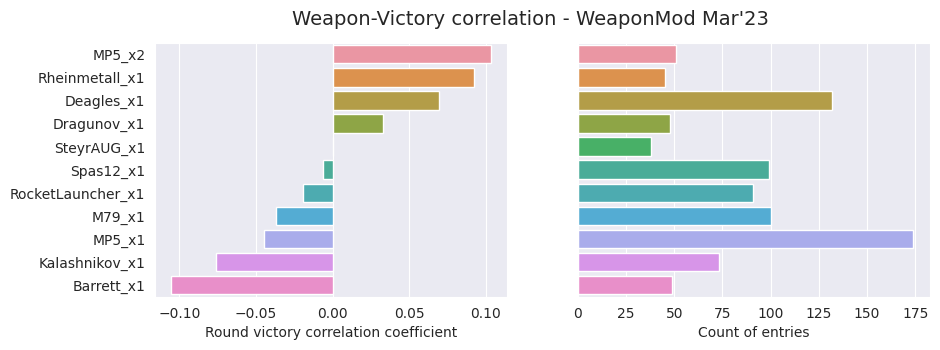

In [4]:
from matplotlib import pyplot as plt

correlation_per_map = tag_correlation_analyzer.calculate_win_correlation()

correlation_df = pd.DataFrame(correlation_per_map.items(), columns=["tag", "corr"])
counts_df = pd.DataFrame(
    tag_correlation_analyzer.tag_counts().items(),
    columns=["tag", "cnt"])

df = pd.merge(correlation_df, counts_df, on=["tag"])


def filter_and_sort_for_corr_charts(df: DataFrame, min_samples):
    df["corr_abs"] = df['corr'].abs()
    df = df[df.apply(lambda x: x["cnt"] > min_samples, axis=1)]
    return df.sort_values("corr_abs", ascending=False) \
        .sort_values("corr", ascending=False)


df = filter_and_sort_for_corr_charts(df, MINIMUM_SAMPLES)

fig, axes = plt.subplots(1, 2, figsize=(CHART_MAX_WIDTH, len(df["corr"]) * CHART_HEIGHT_PER_ENTRY), sharey=True)
fig.suptitle(f"Weapon-Victory correlation - {ACTIVE_WM}", fontsize=14)
sns.barplot(x=df["corr"], y=df["tag"], ax=axes[0]) \
    .set(xlabel="Round victory correlation coefficient", ylabel=None)
sns.barplot(x=df["cnt"], y=df["tag"], ax=axes[1]) \
    .set(xlabel="Count of entries", ylabel=None)

pass

In [5]:
## Each map separately
# from math import ceil
#
# correlation_per_map = tag_correlation_analyzer.calculate_win_correlation_per_map()
# counts_per_map = tag_correlation_analyzer.tag_counts_per_map(NO_RESULT_TAG_FILTER)
#
#
# def correlation_for_map(correlations: DataFrame, counts: DataFrame):
#     df = pd.merge(
#         on=["tag"],
#         left=pd.DataFrame(correlations.items(), columns=["tag", "corr"]),
#         right=pd.DataFrame(counts.items(), columns=["tag", "cnt"]))
#     return df
#
#
# max_corr = 0
# min_corr = 0
# total_entries = 0
# charts = []
# not_enough_data = []
# for map in sorted(list(counts_per_map.keys())):
#     correlations = correlation_per_map[map]
#     counts = counts_per_map[map]
#     df1 = pd.merge(on=["tag"],
#                    left=pd.DataFrame(correlations.items(), columns=["tag", "corr"]),
#                    right=pd.DataFrame(counts.items(), columns=["tag", "cnt"]))
#     df = df1
#     df = filter_and_sort_for_corr_charts(df, min_samples=(MINIMUM_SAMPLES), limit=5)
#     entries_count = len(df["corr"])
#     total_entries += entries_count
#     if entries_count > 0:
#         charts.append((map, df))
#         df_max = df["corr"].max()
#         if df_max > max_corr:
#             max_corr = df_max
#         df_min = df["corr"].min()
#         if df_min < min_corr:
#             min_corr = df_min
#     else:
#         not_enough_data.append(map)
#
# nrows = ceil(len(charts) / 2)
# fig, axes = plt.subplots(nrows, 2, figsize=(CHART_MAX_WIDTH, total_entries / len(charts) * nrows * 0.6),
#                          tight_layout=True)
# axes = axes.flatten()
# print(f"Not enough samples for {len(not_enough_data)} maps")
#
# for i, chart_data in enumerate(charts):
#     map, df = chart_data
#     axes[i].set(xlabel=None, ylabel=None)
#     axes[i].set(xlim=(min_corr, max_corr))
#     sns.barplot(x=df["corr"], y=df["tag"], ax=axes[i]) \
#         .set(title=map, xlabel=None, ylabel=None)

# pass